# Setup

For this notebook we will be pulling chunk data from the PostgreSQL DB and generating responses from the backend server. 
Ensure that both containers are running and that the database is populated with your desired chunks.

To start a single container instead of the entire app run `docker compose up -d <container-name>` from a terminal at the root of this repo.

In [1]:
import os
import json

from dotenv import load_dotenv
from tqdm import tqdm
from ragas.dataset_schema import SingleTurnSample
from ragas.metrics import BleuScore, RougeScore
from sqlalchemy import create_engine, text
from sqlalchemy.engine import URL
from transformers import AutoModel
import matplotlib.pyplot as plt
import requests

load_dotenv()

db_url = URL.create(
    drivername="postgresql+psycopg2",
    username="postgres",
    password=os.environ["POSTGRES_PASSWORD"],
    host="localhost",
    port=5432,
    database="medchat",
)


def get_chunks(engine):
    with engine.connect() as conn:
        result = conn.execute(text("SELECT chunk_id, text FROM chunks"))
    return result.fetchall()

/home/elena/Projects/humana/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
engine = create_engine(db_url, echo=False)

chunks = get_chunks(engine)
print(f"Retrieved {len(chunks)} chunks from the database.\n")
print("Sample chunk data:")
for chunk in chunks[:5]:
    print(f"Chunk ID: {chunk[0]}, Text: {chunk[1][:50]}...")

Retrieved 17 chunks from the database.

Sample chunk data:
Chunk ID: 1, Text: The HER-2/neu oncoFene is a member of the erbB-lik...
Chunk ID: 2, Text: HE EVIDENCE LINKING PROTO-ONCOGENES TO THE INDUC- ...
Chunk ID: 3, Text: More direct evidence comes from the fact that, of ...
Chunk ID: 4, Text: Subsequent sequence analysis and chromo- somal map...
Chunk ID: 5, Text: As a result of the published data showing amplific...


# Load Testset

I manually generated 10 tests, each consisting of a question, sample answer, and list of relevant chunk ids. These questions are designed to cover a wide range of topics from all parts of the documents. Additionally, some questions require information from multiple chunks to answer, thereby increasing the difficulty level and testing the ability to synthesize information from different chunks.

I acknowledge this testing set is still rather small, so all results should be taken lightly. However, the purpose of this notebook is not to give a definitive score for the app's performance, but rather to layout the overall testing framework.

In [ ]:
with open("eval_tests.json", "r") as file:
    eval_tests = json.load(file)

# show sample
eval_tests["1"]

{'question': 'What is HER-2/neu?',
 'sample_answer': 'The HER-2/neu oncogene is a member of the erbB-like oncogene family, and is related to, but distinct firom, the epidermal growth factor receptor. This gene has been shown to be amplified in human breast cancer cell lines.',
 'chunk_ids': [1]}

# Generate Responses

In [4]:
def start_session() -> int:
    resp = requests.post(
        url="http://localhost:5050/start_session",
        json={"user_id": 1},  # User ID 1 is the test user
    )
    session_id = resp.json()
    return session_id


def generate_response(query: str):

    session_id = start_session()

    resp = requests.post(
        url="http://localhost:5050/chat_response",
        json={
            "query": query,
            "chat_history": "",
            "session_id": session_id,
        },
        timeout=120,
    )
    return resp.json()


def generate_eval_responses(test_set: dict):

    for id, test in tqdm(test_set.items()):
        query = test["question"]
        resp = generate_response(query)

        chunk_ids = [chunk["chunk_id"] for chunk in resp["context"]]

        test_set[id]["response"] = resp["response"]
        test_set[id]["retrieved_chunks"] = chunk_ids
        test_set[id]["message_id"] = resp["message_id"]
    return test_set


In [ ]:
test_set = generate_eval_responses(eval_tests)
test_set['1']

100%|██████████| 10/10 [02:33<00:00, 15.36s/it]


{'question': 'What is HER-2/neu?',
 'sample_answer': 'The HER-2/neu oncogene is a member of the erbB-like oncogene family, and is related to, but distinct firom, the epidermal growth factor receptor. This gene has been shown to be amplified in human breast cancer cell lines.',
 'chunk_ids': [1],
 'response': 'The HER-2/neu protein is an oncogene that belongs to the erbB-like family and is distinct from the epidermal growth factor receptor. It is amplified in approximately 30% of breast cancers, correlating with poorer outcomes like relapse and reduced survival. Amplification of HER-2/neu is a strong independent predictor of prognosis, often outperforming traditional markers like hormone receptor status in lymph node-positive breast cancer.',
 'retrieved_chunks': [1, 5],
 'message_id': 39}

**NOTE**: if you would like, you can now shutdown both containers to save resources. We will not be using them again.

# Evaluation Metrics

## Context Retrieval
To evaluate the app's context retrieval we will first measure the precision and recall of the returned chunks for each query. 

As a reminder,

**Recall** measures what fraction of the true (relevant) chunks were actually retrieved.
- For example, if there are 3 relevant chunks in test and the system retrieves 2 of them, recall is 2/3 = 66%.
- High recall ensures the system doesn’t miss important context.

**Precision** measures what fraction of the retrieved chunks are actually relevant.
- For example, if the system retrieves 2 chunks and only 1 are truly relevant, precision is 1/2 = 50%.
- High precision ensures it doesn’t include irrelevant or distracting content.

We will also measure the F1-score of the returned chunks, which is the harmonic mean of precision and recall. This is a good way to distill the recall and precision to a single number.

In [6]:
def compute_context_precision_recall(test_set):
    for test_id, test_data in test_set.items():
        relevant_chunks = set(test_data["chunk_ids"])
        retrieved_chunks = set(test_data["retrieved_chunks"])

        num_tp = len(relevant_chunks & retrieved_chunks)

        # Compute Recall
        if relevant_chunks:
            recall = num_tp / len(relevant_chunks)
        else:
            recall = 0 
        test_set[test_id]["recall"] = recall    

        # Compute Precision
        if retrieved_chunks:
            precision = num_tp / len(retrieved_chunks)
        else:
            precision = 0 
        test_set[test_id]["precision"] = precision

        # Compute F1
        if precision or recall:
            f1 = 2*(precision*recall)/(precision + recall)
        else:
            f1 = 0
        test_set[test_id]["f1"] = f1



compute_context_precision_recall(test_set)
test_set['1']

{'question': 'What is HER-2/neu?',
 'sample_answer': 'The HER-2/neu oncogene is a member of the erbB-like oncogene family, and is related to, but distinct firom, the epidermal growth factor receptor. This gene has been shown to be amplified in human breast cancer cell lines.',
 'chunk_ids': [1],
 'response': 'The HER-2/neu protein is an oncogene that belongs to the erbB-like family and is distinct from the epidermal growth factor receptor. It is amplified in approximately 30% of breast cancers, correlating with poorer outcomes like relapse and reduced survival. Amplification of HER-2/neu is a strong independent predictor of prognosis, often outperforming traditional markers like hormone receptor status in lymph node-positive breast cancer.',
 'retrieved_chunks': [1, 5],
 'message_id': 39,
 'recall': 1.0,
 'precision': 0.5,
 'f1': 0.6666666666666666}

Let's take a look at the results!

In [7]:
# Compute average over all tests

avg_precision = sum(test["precision"] for test in test_set.values()) / len(test_set)
avg_recall = sum(test["recall"] for test in test_set.values()) / len(test_set)
avg_f1 = sum(test["f1"] for test in test_set.values()) / len(test_set)

print(f"Average Precision: {avg_precision:.2f}")
print(f"Average Recall: {avg_recall:.2f}")
print(f"Average F1 Score: {avg_f1:.2f}")

Average Precision: 0.18
Average Recall: 0.30
Average F1 Score: 0.22


In [8]:
# Count tests where no context was retrieved
no_context_tests = sum(1 for test in test_set.values() if not test["retrieved_chunks"])
print(f"Number of tests with no context retrieved: {no_context_tests}")

Number of tests with no context retrieved: 1


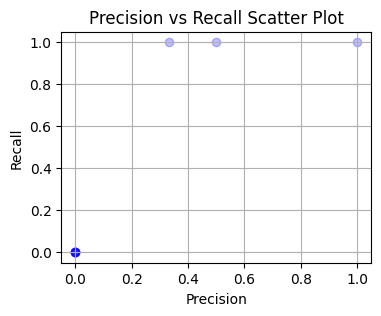

In [9]:
# Plot Precision and Recall for each test
precisions = [test["precision"] for test in test_set.values()]
recalls = [test["recall"] for test in test_set.values()]

# Create scatter plot
plt.figure(figsize=(4, 3))
plt.scatter(precisions, recalls, color='blue', alpha=0.25)
plt.title("Precision vs Recall Scatter Plot")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.grid(True)
plt.show()

In [10]:
zero_precision_recall_tests = sum(
    1 for test in test_set.values() if test["precision"] == 0 and test["recall"] == 0
)
print(f"Number of tests with 0 precision and recall: {zero_precision_recall_tests}")

Number of tests with 0 precision and recall: 7


### Dicussion

Overall, the results are poor, with **7 out of 10 tests scoring 0 on both precision and recall**. However, there are two important observations to highlight:

1. In 2/10 cases the app did not return any chunks at all. This indicates that we may have our `MIN_CHUNK_CROSSENCODER_RELAVANCE` parameter set too high (was 5.0 during this test). 
2. In the remaining 5/10 cases, a quick inspection of the results shows that the app still gave mostly relevant responses. Therefore, it might be the case that my test set was flawed in that the answer to some questions may be contained in chunks other than the listed ones (e.g., I say the answer is contained in Chunk 6 only, when the same information can also be found in Chunk 10).

To evaluate whether the test set is indeed flawed, we need to compare the similarity between the app’s response and the expected answer, which we do in the next section.

## Response Quality

### Traditional NLP Metrics

We will first compare the responses using two traditional NLP metrics: BLEU Score and ROUGE Score.

As a reminder, both metrics can be used to compare a refernce text to a candidate text by measuring the co-occurrences of n-grams. BLEU was originally developed to assess to natural language translation task and ROUGE was developed to evaluate summaries.

Neither metric is particularly well suited for this task, since they only consider n-grams and not more nuanced semantic similarity. However, they are a useful baseline if nothing else.



In [11]:
samples = [
    SingleTurnSample(
        response=test["response"],
        reference=test["sample_answer"]
    )
    for test in test_set.values()
]

In [12]:
scorer = BleuScore()

scores = []
for sample in samples:
    score = await scorer.single_turn_ascore(sample)
    scores.append(score)

print(f"Average BLEU Score: {sum(scores) / len(scores):.2f}")

Average BLEU Score: 0.17


In [13]:
scorer = RougeScore()
for sample in samples:
    score = await scorer.single_turn_ascore(sample)
    scores.append(score)

print(f"Average ROUGE Score: {sum(scores) / len(scores):.2f}")

Average ROUGE Score: 0.19


### Vector Similarity

Another approach is to take the similarity between the embeddings of the given answer and the response. This should hopefully capture some of the richer semantic meaning that is missing in the BLEU and ROUGE scores.

To generate the embeddings I will be using a new model, `BAAI/bge-m3`. This is a general purpose embedding model that scores well on most evaluation sets (see [MTEB Leaderboard](https://huggingface.co/spaces/mteb/leaderboard)).

I am deliberately using a new family of models to avoid data leakage in our evaluations. In more detail
- Using an embedding model from the Qwen family could skew similarity scores upward, as both the generator (Qwen3) and the embedder may have been trained on overlapping data. This could make the responses appear more semantically similar than they actually are.
- Recall the MedCPT models were used to retrieve context that was served as input to the Qwen model during generation. Reusing MEDCPT for evaluation would effectively mean asking the same model to assess the quality of an output that it indirectly influenced. This creates a feedback loop where any semantic alignment introduced during retrieval could artificially inflate the similarity scores. It also risks conflating retrieval performance with response quality, undermining the independence of the evaluation.

An additional benefit of BGE-M3 is that is that it can simultaneously perform the three common retrieval functionalities of embedding model: dense retrieval, multi-vector retrieval, and sparse retrieval. Hence, it's basically 3 vector similarity scores in one, helping us get a more reliable overall similarity.

In [14]:
from FlagEmbedding import BGEM3FlagModel

model = BGEM3FlagModel('BAAI/bge-m3',  use_fp16=True) 

Fetching 30 files: 100%|██████████| 30/30 [03:31<00:00,  7.06s/it]


In [21]:
answers = [test["sample_answer"] for test in test_set.values()]
responses = [test["response"] for test in test_set.values()]

sentence_pairs = [[answer, response] for answer, response in zip(answers, responses)]

scores = model.compute_score(sentence_pairs)

for method in ["colbert", "sparse", "dense"]:
    print(f"Average {method.upper()} Score: {sum(scores[method]) / len(scores[method]):.2f}")

overall_avg = sum(sum(scores[method]) / len(scores[method]) for method in scores.keys()) / len(scores.keys())
print(f"Overall Average Score: {overall_avg:.2f}")

Average COLBERT Score: 0.78
Average SPARSE Score: 0.54
Average DENSE Score: 0.80
Overall Average Score: 0.70


In [ ]:
# Inspect tests with high average scores but 0 precision and recall

for test_id, test_data in test_set.items():
    overall_avg_score = sum(scores[method][int(test_id) - 1] for method in scores.keys()) / len(scores.keys())
    if overall_avg_score > 0.5 and test_data["recall"] == 0 and test_data["precision"] == 0:
        print(f"Test ID: {test_id}")
        print(f"Question: {test_data['question']}")
        print(f"Sample Answer: {test_data['sample_answer']}")
        print(f"Response: {test_data['response']}")
        print(f"Overall Average Score: {overall_avg_score:.2f}\n")

Test ID: 3
Question: What is the clinical significance of HER-2/neu amplification?
Sample Answer: HER-2/neu has been shown to be amplified in human breast cancer cell lines. In the current study, alterations of the gene in 189 primary human breast cancers were investigated. HER-2/neu was found to be amplified from 2- to greater than 20-fold in 30% of the tumors. Correlation of gene amplification with several disease parameters was evaluated. Amplification of the HER-2/neu gene was a significant predictor of both overall survival and time to relapse in patients with breast cancer. It retained its significance even when adjustments were made for other known prognostic factors. Moreover, HER-2/neu amplification had greater prognostic value than most currently used prognostic factors, including hormonal-receptor status, in lymph node-positive disease.
Response: HER2/neu amplification is associated with increased risk of cancer relapse and poorer overall survival in breast cancer patients. 

### LLM Based Scores

In addition to the metrics above, one can also use LLM-graded scores to assess the quality of responses. This involves prompting a large language model to rate or compare responses based on criteria such as correctness, relevance, completeness, or helpfulness.

These methods provide several benefits, namely that:
- LLM's can consider nuance in ways traditional scores cannot, for example sarcasm or negation
- By changing the rubric in the prompts you can emphasize or de-emphasize specific criteria (e.g., don't say anything not fully supported by the context)

However, the inherent randomness of LLM's gives me pause. Before implementing them, I would want to do a study comparing the LLM's scores to human reviewers and measuring their consistency across runs.

For the purposes of this prototype, I also chose to leave them out because I don't have faith in the small models I can run on my hardware to act as reliable reviewers.

## Discussion

Overall, the response quality metrics are promising! 

The BLEU and ROUGE scores were almost universally low, which isn't really surprising given their limitations. However the vector similarity scores are quite high, with an overall average of 0.7 across the three embedding methods.

To test my hypothesis that some of the tests may be flawed, I manually inspected any tests that had an overall vector similarity > 0.5, recall = 0, and precision = 0. 6 of the 7 tests that had 0 precision and recall satisfied these conditions. 

In my subjective opinion, I would only classify one of these tests (test 3) as a "False Positive", i.e., one of the test had an irrelevant response that nonetheless scored high. For the remaining 5 tests, I found the model's answer to be relevant and agree with the sample answer, though in some cases the model's answer had less details. This supports the hypothesis that these 5 tests may be flawed, and adding additional relevant context chunks to the answers would give a better indicator of performance.